In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import time
print(os.listdir("../input"))

import matplotlib.pyplot as plt

#Machine Learning Imports
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Ml Core Algo Libraries
import lightgbm as lgb
import sklearn

#Deep Learning Imports
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization
from keras.losses import binary_crossentropy, mse
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Competition Starter Kit
from kaggle.competitions import twosigmanews

#Gen imports
from itertools import chain

['marketdata_sample.csv', 'news_sample.csv']


Using TensorFlow backend.


In [2]:
#Create the env and get the data
env = twosigmanews.make_env()
(market_train, news_train) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [3]:
#Define News Columns
news_cols_agg = {
    'urgency': ['min', 'count'],
    'takeSequence': ['max'],
    'bodySize': ['min', 'max', 'mean', 'std'],
    'wordCount': ['min', 'max', 'mean', 'std'],
    'sentenceCount': ['min', 'max', 'mean', 'std'],
    'companyCount': ['min', 'max', 'mean', 'std'],
    'marketCommentary': ['min', 'max', 'mean', 'std'],
    'relevance': ['min', 'max', 'mean', 'std'],
    'sentimentNegative': ['min', 'max', 'mean', 'std'],
    'sentimentNeutral': ['min', 'max', 'mean', 'std'],
    'sentimentPositive': ['min', 'max', 'mean', 'std'],
    'sentimentWordCount': ['min', 'max', 'mean', 'std'],
    'noveltyCount12H': ['min', 'max', 'mean', 'std'],
    'noveltyCount24H': ['min', 'max', 'mean', 'std'],
    'noveltyCount3D': ['min', 'max', 'mean', 'std'],
    'noveltyCount5D': ['min', 'max', 'mean', 'std'],
    'noveltyCount7D': ['min', 'max', 'mean', 'std'],
    'volumeCounts12H': ['min', 'max', 'mean', 'std'],
    'volumeCounts24H': ['min', 'max', 'mean', 'std'],
    'volumeCounts3D': ['min', 'max', 'mean', 'std'],
    'volumeCounts5D': ['min', 'max', 'mean', 'std'],
    'volumeCounts7D': ['min', 'max', 'mean', 'std']
}


In [4]:
#Define Join procedure for Market and News Data
def join_market_news(market_train_df, news_train_df):
    # Fix asset codes (str -> list)
    news_train_df['assetCodes'] = news_train_df['assetCodes'].str.findall(f"'([\w\./]+)'")    
    
    # Expand assetCodes
    assetCodes_expanded = list(chain(*news_train_df['assetCodes']))
    assetCodes_index = news_train_df.index.repeat( news_train_df['assetCodes'].apply(len) )

    assert len(assetCodes_index) == len(assetCodes_expanded)
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

    # Create expandaded news (will repeat every assetCodes' row)
    news_cols = ['time', 'assetCodes'] + sorted(news_cols_agg.keys())
    news_train_df_expanded = pd.merge(df_assetCodes, news_train_df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))

    # Free memory
    del news_train_df, df_assetCodes

    # Aggregate numerical news features
    news_train_df_aggregated = news_train_df_expanded.groupby(['time', 'assetCode']).agg(news_cols_agg)
    
    # Free memory
    del news_train_df_expanded

    # Convert to float32 to save memory
    news_train_df_aggregated = news_train_df_aggregated.apply(np.float32)

    # Flat columns
    news_train_df_aggregated.columns = ['_'.join(col).strip() for col in news_train_df_aggregated.columns.values]

    # Join with train
    market_train_df = market_train_df.join(news_train_df_aggregated, on=['time', 'assetCode'])

    # Free memory
    del news_train_df_aggregated
    
    return market_train_df

In [5]:
#Splitting Data into X and Y and encoding the data
def get_xy(market_train_df, news_train_df, le=None):
    x, le = get_x(market_train_df, news_train_df)
    y = market_train_df['returnsOpenNextMktres10'].clip(-1, 1)
    return x, y, le

def label_encode(series, min_count):
    vc = series.value_counts()
    le = {c:i for i, c in enumerate(vc.index[vc >= min_count])}
    return le

def get_x(market_train_df, news_train_df, le=None):
    # Split date into before and after 22h (the time used in train data)
    # E.g: 2007-03-07 23:26:39+00:00 -> 2007-03-08 00:00:00+00:00 (next day)
    #      2009-02-25 21:00:50+00:00 -> 2009-02-25 00:00:00+00:00 (current day)
    news_train_df['time'] = (news_train_df['time'] - np.timedelta64(22,'h')).dt.ceil('1D')

    # Round time of market_train_df to 0h of curret day
    market_train_df['time'] = market_train_df['time'].dt.floor('1D')

    # Join market and news
    x = join_market_news(market_train_df, news_train_df)
    
    # If not label-encoder... encode assetCode
    if le is None:
        le_assetCode = label_encode(x['assetCode'], min_count=10)
        le_assetName = label_encode(x['assetName'], min_count=5)
    else:
        #'unpack' label encoders
        le_assetCode, le_assetName = le
        
    #x['assetCode'] = x['assetCode'].map(le_assetCode).fillna(-1).astype(int)
    x['assetName'] = x['assetName'].map(le_assetName).fillna(-1).astype(int)
    # Fix some mixed-type columns
    for bogus_col in ['marketCommentary_min', 'marketCommentary_max']:
        x[bogus_col] = x[bogus_col].astype(float)
    
    return x, (le_assetCode, le_assetName)

In [6]:
#Pick Data Sample - Try with 30k, 300k, 3M. Setting to 3M for final run.
merged_data, _ = get_x(market_train.tail(300000), news_train.tail(600000))
#print (merged_data.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

In [7]:
#Defining the categorical and numerical columns. Categorical Columns will be feeded separately into the NN through cat layers after encoding. 
#Numerical columns will be feeded directly.

cat_cols = ['assetCode', 'assetName']
num_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
                    'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
                    'returnsOpenPrevMktres10']#, 'urgency_min', 'relevance_mean', 'sentimentNegative_mean', 'sentimentNeutral_mean',
    #'sentimentPositive_mean', 'noveltyCount24H_mean', 'volumeCounts24H_mean']


In [8]:
market_train = merged_data

train, validate, test = np.split(merged_data.sample(frac=1), [int(.6*len(merged_data)), int(.8*len(merged_data))])

#Debug code
#print (train)
#print(validate)
#print (test)

train_indices = train.index.values
val_indices = validate.index.values
test_indices = test.index.values

In [9]:
#Categorical Columns Processing: Encoding of the categorical variables

def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

encoders = [{} for cat in cat_cols]

for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(market_train.loc[train_indices, cat].astype(str).unique())}
    market_train[cat] = market_train[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

#Handling the unknown assets: Using +1 for unknown
embed_sizes = [len(encoder) + 1 for encoder in encoders]

encoding assetCode ... Done
encoding assetName ... Done


In [10]:
#Numerical Columns Processing: Scaling Numerical Columns
#Inspired by the Baseline implementation by https://www.kaggle.com/christofhenkel/market-data-nn-baseline
market_train[num_cols] = market_train[num_cols].fillna(0)

scaler = StandardScaler()
market_train[num_cols] = scaler.fit_transform(market_train[num_cols])

In [11]:
#Defining the NN Architecture: Using the MSE as a Loss. tanh output activation since confidence is between -1.0 and 1.0

categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[len(cat_cols)], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)

numerical_inputs = Input(shape=(len(num_cols),), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='tanh')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=mse)

#model.summary()

In [12]:
def get_input(market_train, indices):
    X_num = market_train.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = market_train.loc[indices, cat_cols].values
    y = (market_train.loc[indices,'returnsOpenNextMktres10'] >= 0).values
    r = market_train.loc[indices,'returnsOpenNextMktres10'].values
    u = market_train.loc[indices, 'universe']
    d = market_train.loc[indices, 'time'].dt.date
    return X,y,r,u,d

# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(market_train, train_indices)
X_valid,y_valid,r_valid,u_valid,d_valid = get_input(market_train, val_indices)
X_test,y_test,r_test,u_test,d_test = get_input(market_train, test_indices)

In [13]:
check_point = ModelCheckpoint('model.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)

#Regression type fitting
model.fit(X_train,r_train,
          validation_data=(X_valid,r_valid),
          epochs=5,
          verbose=True,
          callbacks=[early_stop,check_point])

Train on 180000 samples, validate on 60000 samples
Epoch 1/5
180000/180000 [==============================] - 11s 62us/step - loss: 0.0048 - val_loss: 0.0041

Epoch 00001: val_loss improved from inf to 0.00410, saving model to model.hdf5
Epoch 2/5
180000/180000 [==============================] - 10s 58us/step - loss: 0.0045 - val_loss: 0.0041

Epoch 00002: val_loss improved from 0.00410 to 0.00406, saving model to model.hdf5
Epoch 3/5
180000/180000 [==============================] - 10s 58us/step - loss: 0.0045 - val_loss: 0.0041

Epoch 00003: val_loss did not improve from 0.00406
Epoch 4/5
180000/180000 [==============================] - 10s 58us/step - loss: 0.0044 - val_loss: 0.0041

Epoch 00004: val_loss did not improve from 0.00406
Epoch 5/5
180000/180000 [==============================] - 11s 59us/step - loss: 0.0043 - val_loss: 0.0040

Epoch 00005: val_loss improved from 0.00406 to 0.00397, saving model to model.hdf5


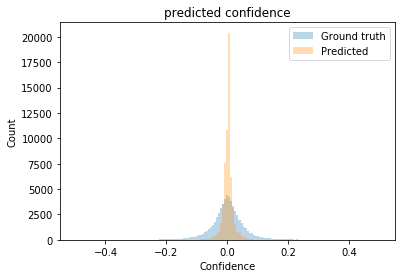

In [14]:
#plot confidence interval
y_pred = model.predict(X_test)[:,0]
plt.hist(r_test, bins=np.linspace(-0.5,0.5,150), alpha=0.3)
plt.hist(y_pred, bins=np.linspace(-0.5,0.5,150), alpha=0.3, color='darkorange')
plt.legend(['Ground truth', 'Predicted'])
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("predicted confidence")
plt.show()

In [15]:
#Print Accuracies
print(accuracy_score(model.predict(X_train)[:,0]>0,y_train))
print(accuracy_score(model.predict(X_valid)[:,0]>0,y_valid))
print(accuracy_score(model.predict(X_test)[:,0]>0,y_test))

0.5921277777777778
0.5748166666666666
0.5822333333333334


In [16]:
#Print MSEs
print(mean_squared_error(model.predict(X_train)[:,0],r_train))
print(mean_squared_error(model.predict(X_valid)[:,0],r_valid))
print(mean_squared_error(model.predict(X_test)[:,0],r_test))

0.00431734470105933
0.0039687078765746325
0.004493260021211155


In [17]:
def error_histogram(y_pred, y_true):
    plt.style.use("seaborn-paper")
    error = np.subtract(np.array([float(y) for y in y_pred]), y_true)
    print(np.std(error))
    plt.hist(error, bins = np.linspace(-0.25, 0.25, 100), alpha=0.3, color='r')
    plt.xlabel("Error in 10-day return")
    plt.ylabel("Frequency")
    plt.title("Error Histogram")
    plt.show()

0.06700052699418939


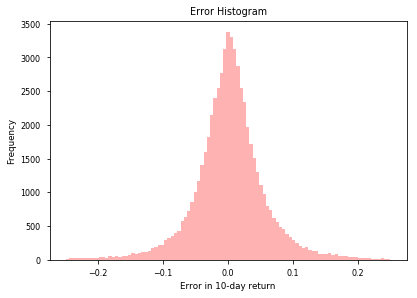

In [18]:
error_histogram(model.predict(X_test)[:,0],r_test)

In [19]:
#Competition Submission
days = env.get_prediction_days()

In [ ]:
#Make predictions and save file
"""
n_days = 0
predicted_confidences = np.array([])
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days += 1
    
    market_obs_df_updated, _ = get_x(market_obs_df, news_obs_df)
    
    for i, cat in enumerate(cat_cols):
        market_obs_df_updated[cat] = market_obs_df_updated[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    
    market_obs_df_updated[num_cols] = market_obs_df_updated[num_cols].fillna(0)
    market_obs_df_updated[num_cols] = scaler.transform(market_obs_df_updated[num_cols])
    
    X_num_test = market_obs_df_updated[num_cols].values
    X_test = {'num':X_num_test}
    for cat in cat_cols:
        X_test[cat] = market_obs_df_updated[cat_cols].values    
    
    market_prediction = model.predict(X_test)[:,0]
    
    predicted_confidences = np.concatenate((predicted_confidences, market_prediction))
    
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':market_prediction})
    # insert predictions to template
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    predictions_template_df.confidence_value = market_prediction
    env.predict(predictions_template_df)
    
env.write_submission_file()
"""